### Collecting information for building the dataset

To obtain the information we will use this API: 
- https://github.com/swar/nba_api

    This is a Python library that can be used to obtain data from stats.nba.com, it provides a set of methods that abstracts you from making the http calls, but directly makes calls to nba stats page and parses the results. [Here](https://github.com/swar/nba_api/blob/master/docs/examples/Basics.ipynb) are a couple of examples on how to use it.

In [101]:
# import cell

from nba_api.stats.static import players
from nba_api.stats.endpoints import commonallplayers
from nba_api.stats.endpoints import commonplayerinfo
from nba_api.stats.endpoints import playercareerstats
import time
import pandas as pd
import numpy as np
import gdown
import requests
import random
from unidecode import unidecode
from datetime import datetime, date
from dateutil import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns
import folium

1.1

- Create a function to find all ACTIVE players, meaning players that are listed with a team in the 2021/2022 season.
- Save the dataframe to a csv named "nba_current_players_list.csv".


Consider dropping: 
- All players with GAMES_PLAYED_FLAG == N
- Players with id 1630597 & 1630492 (These guys are a problem ;))


In [2]:
def get_and_save_players_list():
    """
    Funtion that find all active players in the NBA.

    This funtion will get all the players in the history of the NBA using the enpoint commonallplayers.CommonAllPlayers(),
    after that it will filter by the TEAM_ID == 0 (That means they have no team)

    Parameters
    ----------
    None:
        Don't need pass any parameters

    Returns
    -------
    active_players:
        A pandas DataFrame with all actives player in the current season
    """
#     get all the players and create a df with them
    players_df = commonallplayers.CommonAllPlayers().get_data_frames()[0]
#     filter the active players
    active_players = players_df[(players_df['TEAM_ID'] != 0) &
                         (players_df['GAMES_PLAYED_FLAG'] != 'N') &
                         (players_df['PERSON_ID'] != {1630597, 1630492})]

    return active_players

In [3]:
current_players_list = get_and_save_players_list()
current_players_list.to_csv("nba_current_players_list.csv")

1.2
- Create a function to find the personal information of all players listed in the dataframe created in the previous step
- Save it to a csv file named "nba_players_personal_info.csv"

In [4]:
def get_players_personal_information(current_players_list):
    """
    Find players personal information (name, age, dob, etc) using the commonplayerinfo.CommonPlayerInfo() enpoint.

    Parameters
    ----------
    current_players_list: Padas DF.
        DF with the information of the player, at least the "PERSON_ID" to search the personal information.

    Returns
    -------
    player_information: Pandas DF.
      DF with players personal information. 
    """
    # empty DF
    player_information = pd.DataFrame()
    # loop to get player information one by one
    for id in current_players_list['PERSON_ID']:
      # sleep to not be blocked by the API
      time.sleep(.5)
      try:
        info_df = commonplayerinfo.CommonPlayerInfo(player_id = id).get_data_frames()[0]
        player_information = pd.concat([player_information, info_df])
      except:
        print(f"Somenthing happen with the player id={id}")
    player_information.rename(columns = {'DISPLAY_FIRST_LAST':'PLAYER_NAME'}, inplace = True)

    return player_information

In [5]:
players_personal_info = get_players_personal_information(current_players_list)
players_personal_info.to_csv("nba_players_personal_info.csv")

1.3
- Create a function to find players career statistics.
- Store the information in a CSV file called "nba_players_career_stats.csv"

In [6]:
def get_players_career_stats(current_players_list):
    """
    find players career stats using the playercareerstats.PlayerCareerStats() enpoint.

    Parameters
    ----------
    current_players_list: Padas DF.
        DF with the information of the player, at least the "PERSON_ID" to search the personal information.

    Returns
    -------
    player_information: Pandas DF.
      DF with players career stats. 
    """
    # empty DF
    players_career_stats = pd.DataFrame()
    # loop to get player information one by one
    for id in current_players_list['PERSON_ID']:
      try:
        # sleep to not be blocked by the API
        time.sleep(.5)
        stats_df = playercareerstats.PlayerCareerStats(player_id = id).career_totals_regular_season.get_data_frame()
        players_career_stats = pd.concat([players_career_stats, stats_df])
      except:
        print(f"Somenthing happen with the player id={id}")

    return players_career_stats

In [7]:
players_career_stats = get_players_career_stats(current_players_list)
players_career_stats.to_csv("nba_players_career_stats.csv")

Somenthing happen with the player id=1631099


1.4
- Create a function to find players salary for this season. The list of players and salaries from this file: [contracts.csv](https://drive.google.com/file/d/1bxjuIZfMS2_kickukdC3ggdXIVeZE5y7/view?usp=sharing). Download and use this file as input for your function `get_nba_players_salaries()`.
- Save the information to a csv called "nba_players_salary.csv".

In [8]:
# download the data set
!gdown https://drive.google.com/uc?id=1bxjuIZfMS2_kickukdC3ggdXIVeZE5y7

Downloading...
From: https://drive.google.com/uc?id=1bxjuIZfMS2_kickukdC3ggdXIVeZE5y7
To: /home/danrambado/AnyoneAI/Sprint_1/contracts.csv
100%|██████████████████████████████████████| 41.8k/41.8k [00:00<00:00, 9.37MB/s]


In [9]:
def get_nba_players_salaries(csv_file_path, players_personal_info):
    """
    Find the salary of players who are in a dataframe.

    Parameters
    ----------
    csv_file_path: str.
      Path to the csv.
    players_personal_info: Pandas DF.
      DF with the players information.

    Returns
    -------
    salary2122: Pandas DF.
      DF with players salary in the season 2021-2022
    
    """
    salary = pd.read_csv(csv_file_path)
    # Rename the columns name
    salary.rename(columns = {'Unnamed: 1':'PLAYER_NAME', 'Salary':'SALARY'}, inplace = True)

    # Format the salary values
    salary['SALARY'] = salary['SALARY'].str.replace('$','')

    # Format the names 
    names = salary['PLAYER_NAME'].str.split(pat= '\\')
    names = [x[:][0] for x in names]
    names = [unidecode(x) for x in names]

    # Replace the names
    salary = salary.replace(
    to_replace = [x for x in salary['PLAYER_NAME']],
    value = [x for x in names]
    )

    # Filter the salaries dataframe in base a players_personal_info['DISPLAY_FIRST_LAST'] 
    # and clean the data (drop the NuN and duplicate values)
    salary2122 = salary.loc[salary['PLAYER_NAME'].isin(players_personal_info['PLAYER_NAME'])]
    salary2122 = salary2122[['PLAYER_NAME', 'SALARY']].dropna()
    salary2122 = salary2122.drop_duplicates(subset=['PLAYER_NAME'])

    return salary2122

In [10]:
players_salaries = get_nba_players_salaries("contracts.csv", players_personal_info)
players_salaries.to_csv("nba_players_salary.csv")

/tmp/ipykernel_1760/463181746.py:23: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  salary['SALARY'] = salary['SALARY'].str.replace('$','')


1.5
- Create a function to merge the created dataframes: players_personal_info, players_career_stats, players_salaries. For each dataframe, select only the subset of columns needed to create the dataset described in section "The Dataset"

    - Players info: "PLAYER_NAME", "TEAM_NAME", "POSITION", "HEIGHT", "WEIGHT", "COUNTRY", "BIRTHDATE", "SEASON_EXP", "DRAFT_NUMBER"
    - Players stats: "GP", "MIN", "PTS", "REB", "AST", "STL", "BLK"
    - Misc: "SALARY"

- Save the result to a csv called "raw_nba_players_dataset.csv"

In [12]:
### Complete in this cell: merge the dataframes

def merge_dataframes(players_personal_info, players_career_stats, players_salaries, features):
     """ 
     Merge data frame by PERSON_ID
     Parameters
     ----------
     players_personal_info: Pandas DF.
          DF with the players information.
     players_career_stats: Pandas DF.
          DF with the players stats.
     players_salaries: Pandas DF.
          DF with the players salary.
     features: List
          A list specifying the features to keep.
     Returns
     -------
     final_merge: Pandas DF.
          DF with all the information.
     """
     # Rename the columns to make more easy merge then 
     players_personal_info.rename(columns = {'DISPLAY_FIRST_LAST':'PLAYER_NAME'}, inplace = True)

     # Reset the index of players_personal_info and players_career_stats data frame
     df_info = players_personal_info.set_index('PERSON_ID')
     df_stats = players_career_stats.set_index('PLAYER_ID')

     # Merge players_personal_info and players_career_stats
     first_merge = pd.concat([df_info, df_stats], axis = 1)

     # Final merge with the players_salaries
     # Use .merge() method with base on 'PLAYER_NAME' and to keep all values
     # using the how='left'
     final_merge = first_merge.merge(players_salaries, on= 'PLAYER_NAME', how= 'left')

     # Filter only the columns that we need
     final_merge = final_merge[features]

     return final_merge

In [13]:
features = ["PLAYER_NAME", "TEAM_NAME", "POSITION", "HEIGHT", 
          "WEIGHT", "COUNTRY", "BIRTHDATE", "SEASON_EXP", "DRAFT_NUMBER",
          "GP", "MIN", "PTS", "REB", "AST", "STL", "BLK", "SALARY"]
raw_players_dataset = merge_dataframes(players_personal_info, players_career_stats, players_salaries, features)
raw_players_dataset.to_csv("raw_nba_players_dataset.csv")

## Data Cleaning and Preprocessing

Points to follow to clean and preprocess the data set.
- Height and weight might need to be converted to the metric system
- Players that have no team assigned should be removed from the dataset
- Players with no contracts (meaning they don't have a salary defined) should be removed from the dataset
- If the "position" data is ambiguous (listed at multiple positions), use the first value
- If the player does not have height or weight data, use the average for its position as its value

2.1
- Create a copy of the dataset named "working_df" removing all players with no teams or salary

In [79]:
### Complete in this cell: copy the dataset and drop NaNs in team or salary
def copy_and_delete_nan(raw_players_dataset):
    """
    Create a copy of a dataset and remove the players with nans values
    in features SALARY and TEAM_NAME
    Parameters
    ----------
    raw_players_dataset: Pandas DF.
        DF that will be a copied.
    Returns
    -------
    working_df: Pandas DF.
        DF copy, clean.
    """
    working_df = raw_players_dataset
    working_df = working_df.dropna(subset= ["SALARY","TEAM_NAME"])
    return working_df

In [80]:
working_df = copy_and_delete_nan(raw_players_dataset)

2.2
- Cast Salary and Birthday columns to its corresponding type (int, datetime)

In [81]:
### Cast all columns to its type
def cast_columns(working_df):
    working_df = working_df.astype({'SALARY':'int64'})
    working_df = working_df.astype({'BIRTHDATE':'datetime64[ns]'})
    return working_df

In [82]:
working_df = cast_columns(working_df)

2.3
- Converts the height column from height in feet and inches to centimeters.

In [83]:
### Convert height column
def convert_height_column(working_df):
    conversions = [30.48, 2.54]
    # Split and aply the method "dot" ()
    working_df['HEIGHT'] = working_df['HEIGHT'].str.split('-').apply(pd.Series).astype(int).dot(conversions).round()

In [84]:
convert_height_column(working_df)

2.4
- Function that converts the weight column from pounds to kilograms.

In [85]:
### Convert weight column
def convert_weight_column(working_df):
    # Define the necesary variables 
    conversion = 2.205
    working_df = working_df.astype({'WEIGHT':'float'})
    working_df['WEIGHT'] = working_df['WEIGHT'].apply(lambda x: x / conversion).round()
    return working_df['WEIGHT']

2.5
- Function that calculates the age in (years, months, days) and saves it in a new string column named "AGE", example: "22 years, 5 months, 25 days" 

In [86]:
### Add age column
def add_age_column(working_df):
    # Define the necesary variables 
    today = pd.to_datetime("today")
    age_list = []

    for date in working_df['BIRTHDATE']:
      # Use relativedelta to calculete the years, months and days from today
      delta = relativedelta.relativedelta(today, date)
      age = f"{delta.years} years, {delta.months} months, {delta.days} days"
      age_list.append(age)

    working_df['AGE'] = age_list
    return working_df

In [ ]:
add_age_column(working_df)

2.6
- Function that takes care of the disambiguation of the "POSITION" column. Replace all positions that are mixed with the first one listed.

In [88]:
### Disambiguation of the position column
def update_position(working_df):
    working_df['POSITION'] = working_df['POSITION'].apply(lambda x: x.split('-')[0])
    return working_df

In [89]:
working_df = update_position(working_df)

2.7
- Save it as a csv with name "nba_players_processed_dataset.csv"

In [91]:
working_df.to_csv("nba_players_processed_dataset.csv")

## EDA

3.1
- Calculate and print the following metrics:

    - General metrics:
        - Total number of players
        - Number of USA born players
        - Number of foreign players
        - Number of players per position
        - Number of players per team
        - Number of rookies (first year players)
    - Players description
        - Average player age (in years)
        - Youngest player age (as a string, like: "22 years, 5 months, 25 days")
        - Oldest player age (as a string, like: "40 years, 2 months, 3 days")
        - Min and Max players height
        - Average height of players per position
    - Contracts
        - Min and Max salary of all players
        - Mean and Median salary of all players

In [92]:
### General metrics
# Calculate the points
gm_a = len(working_df['PLAYER_NAME'])
gm_b = working_df['COUNTRY'][working_df['COUNTRY'] == 'USA'].count()
gm_c = working_df['COUNTRY'][working_df['COUNTRY'] != 'USA'].count()
gm_d = str(working_df['POSITION'].value_counts())[:44]
gm_f = str(working_df['TEAM_NAME'].value_counts())[:599]
gm_g = working_df['SEASON_EXP'][working_df['SEASON_EXP'] == 1].count()

print(  f"""- General metrics:

- Total number of players = {gm_a}
- Number of USA born players = {gm_b}
- Number of foreign players = {gm_c}
- Number of players per position =
{gm_d}

- Number of players per team =
{gm_f}
- Number of rookies (first year players) = {gm_g}
        """
      )

- General metrics:

- Total number of players = 384
- Number of USA born players = 288
- Number of foreign players = 96
- Number of players per position =
Guard      175
Forward    154
Center      55

- Number of players per team =
76ers            15
Bucks            14
Cavaliers        14
Knicks           14
Wizards          14
Suns             14
Hornets          14
Bulls            14
Spurs            13
Clippers         13
Warriors         13
Nets             13
Hawks            13
Mavericks        13
Pelicans         13
Magic            13
Heat             13
Kings            12
Pistons          12
Lakers           12
Pacers           12
Celtics          12
Nuggets          12
Trail Blazers    12
Rockets          12
Timberwolves     12
Jazz             12
Raptors          12
Grizzlies        11
Thunder          11
- Number of rookies (first year players) = 52
        


In [93]:
### Players descriptions

# Calculate the points
pda = pd.Series([int(age[:2]) for age in working_df['AGE']]).mean().round()
pdb = working_df.AGE.loc[working_df[working_df['BIRTHDATE']== working_df['BIRTHDATE'].max()].index.values[0]]
pdc = working_df.AGE.loc[working_df[working_df['BIRTHDATE']== working_df['BIRTHDATE'].min()].index.values[0]]
pdd1 = working_df['HEIGHT'].min()
pdd2 = working_df['HEIGHT'].max()
pde = working_df.groupby('POSITION').mean().round()['HEIGHT']


print(  f"""- Players description
- Average player age = {pda}
- Youngest player age = {pdb}
- Oldest player age = {pdc}
- Min players height = {pdd1}
- Max players height = {pdd2}
- Average height of players per position = 
{pde}
        """
      )

- Players description
- Average player age = 27.0
- Youngest player age = 20 years, 1 months, 26 days
- Oldest player age = 42 years, 5 months, 27 days
- Min players height = 183.0
- Max players height = 224.0
- Average height of players per position = 
POSITION
Center     211.0
Forward    204.0
Guard      193.0
Name: HEIGHT, dtype: float64
        


/tmp/ipykernel_1760/1619162699.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pde = working_df.groupby('POSITION').mean().round()['HEIGHT']


In [94]:
### Contracts

# Calculate the points
ca = working_df['SALARY'].min()
cb = working_df['SALARY'].max()
cc = int(working_df['SALARY'].mean().round())
cd = working_df['SALARY'].median()

print(  f"""- Players description
- Min salary of all players = {ca} USD
- Max salary of all players = {cb} USD
- Mean salary of all players =  {cd} USD
- Median salary of all players =  {cc} USD
        """
      )

- Players description
- Min salary of all players = 85578 USD
- Max salary of all players = 45780966 USD
- Mean salary of all players =  5137862.0 USD
- Median salary of all players =  9595231 USD
        


3.2
- Ploting the relationship between scoring (points per game) and salary of all players, the players positions also will be visible.

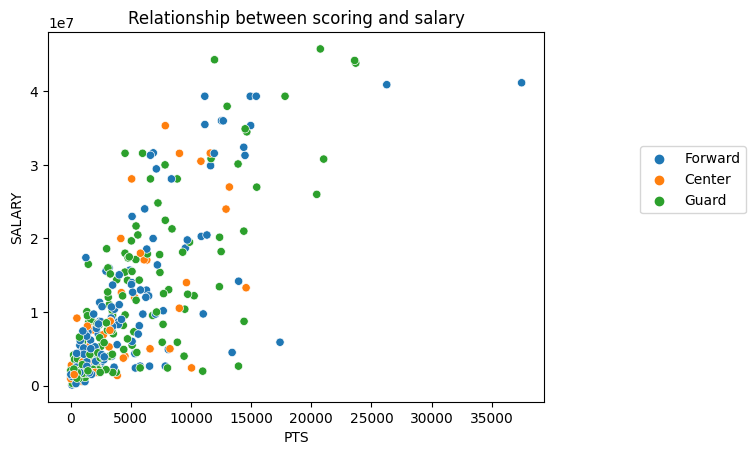

In [95]:
### Relationship between scoring and salary (in millions of dollars)
sns.scatterplot(data= working_df, x='PTS', y='SALARY', hue='POSITION').set(title='Relationship between scoring and salary')
plt.legend(loc='center',bbox_to_anchor=(1.30,.6))
plt.show()

3.3
- Plotting assists-vs-salary and rebounding-vs-salary

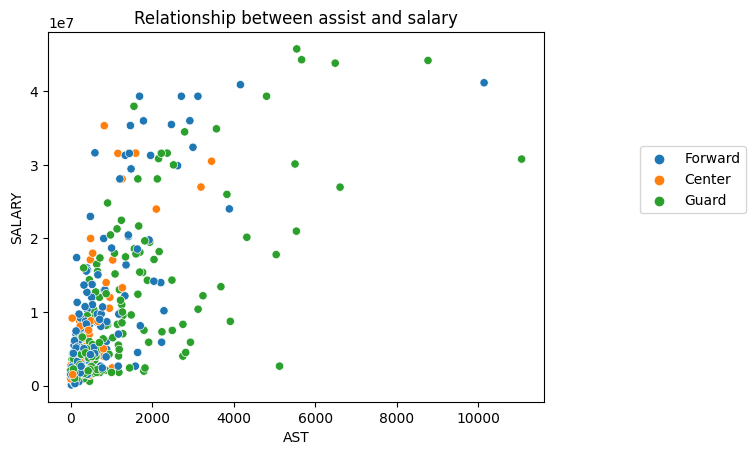

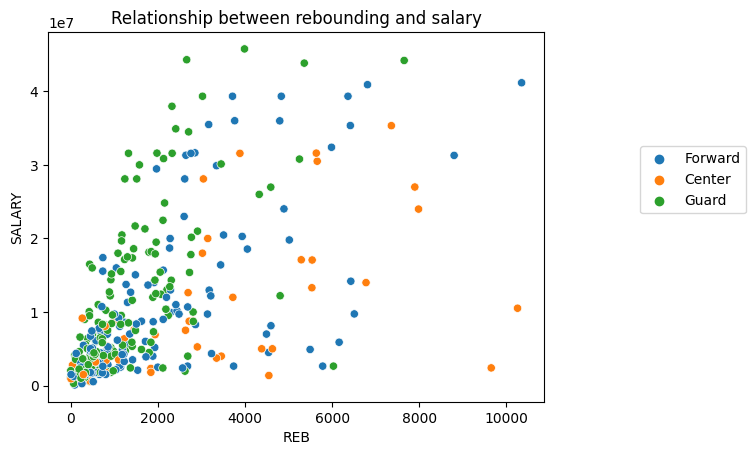

In [96]:
### Ploting assist-vs-salary, rebounding-vs-salary
sns.scatterplot(data= working_df, x='AST', y='SALARY', hue='POSITION').set(title='Relationship between assist and salary')
plt.legend(loc='center',bbox_to_anchor=(1.30,0.6))
plt.show()
sns.scatterplot(data= working_df, x='REB', y='SALARY', hue='POSITION').set(title='Relationship between rebounding and salary')
plt.legend(loc='center',bbox_to_anchor=(1.30,0.6))
plt.show()

3.4
- When NBA players enter the league, they have low value salaries during what is called their "rookie contract". This means that it doesn't matter how well the player performs, they can't have large salaries. This can distort our understanding of how much teams value each skill, as a player could score 50 points a game and still earn just a couple of millions. 
So, lets now plot points, assists and rebounding vs salary, but only for players that have more than 4 years of experience (the typical length of a rookie contract)

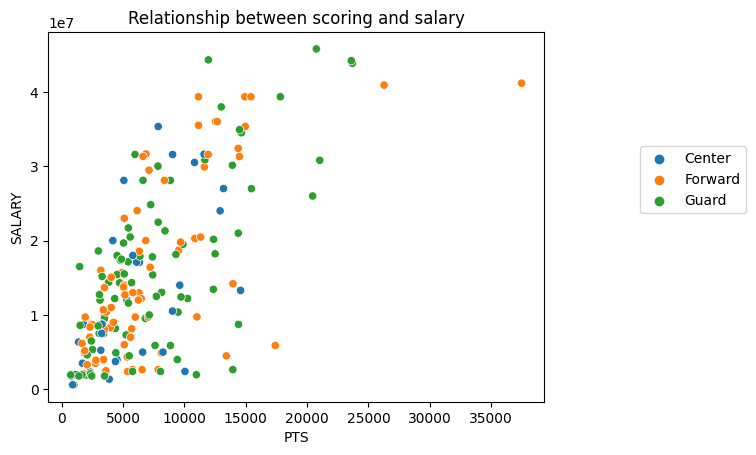

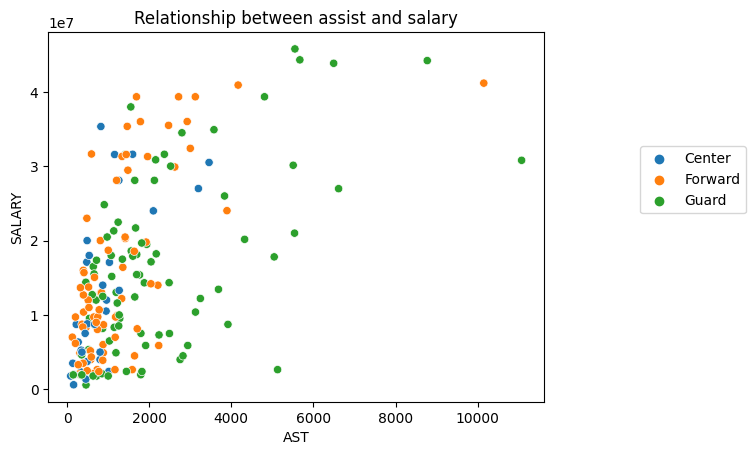

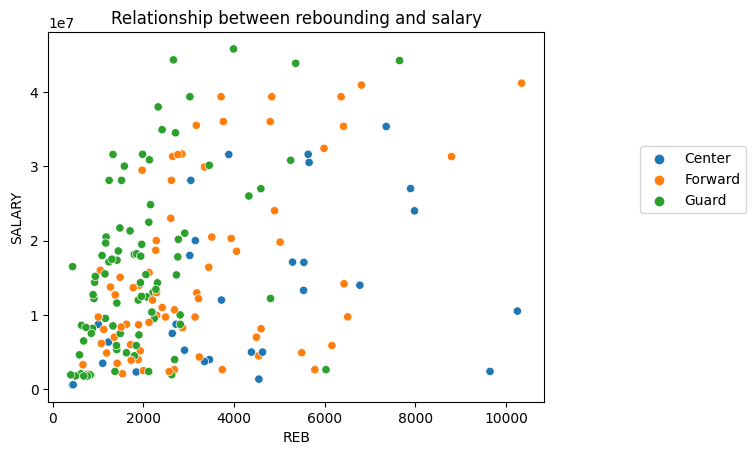

In [97]:
### Non rookie contracts
# Filter the non rookie contracts
non_rookie_contracts = working_df[working_df['SEASON_EXP']>4]

sns.scatterplot(data= non_rookie_contracts, x='PTS', y='SALARY', hue='POSITION').set(title='Relationship between scoring and salary')
plt.legend(loc='center',bbox_to_anchor=(1.30,.6))
plt.show()
sns.scatterplot(data= non_rookie_contracts, x='AST', y='SALARY', hue='POSITION').set(title='Relationship between assist and salary')
plt.legend(loc='center',bbox_to_anchor=(1.30,0.6))
plt.show()
sns.scatterplot(data= non_rookie_contracts, x='REB', y='SALARY', hue='POSITION').set(title='Relationship between rebounding and salary')
plt.legend(loc='center',bbox_to_anchor=(1.30,0.6))
plt.show()

3.5
- Ploting the scoring average grouped by position with the median, quartiles, etc.

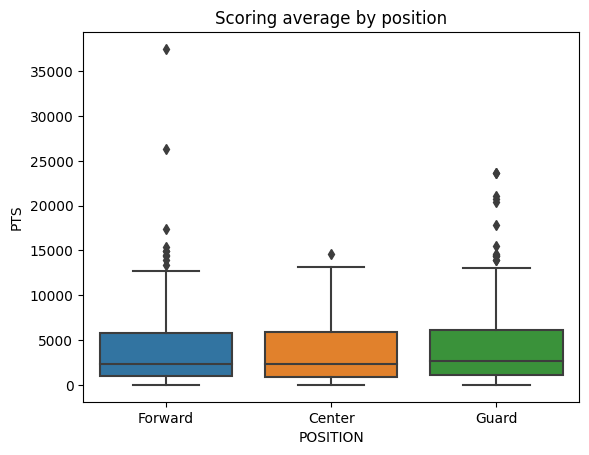

In [98]:
### Scoring average grouped by position
sns.boxplot(data= working_df, x='POSITION', y='PTS').set(title='Scoring average by position')
plt.show()

3.6
- Ploting the Height distribution of all players

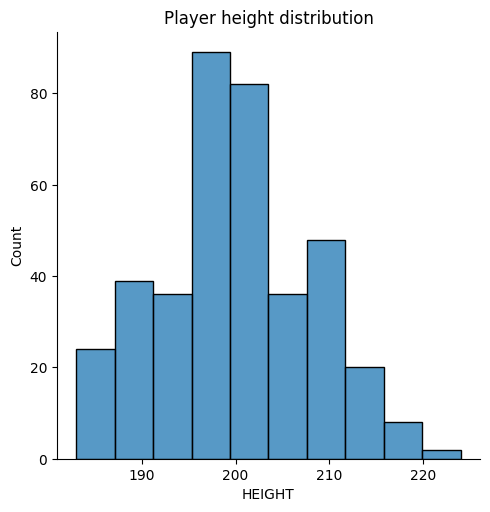

In [99]:
### Height distribution
sns.displot(data=working_df, x="HEIGHT", kind="hist", bins=10).set(title='Player height distribution')
plt.show() 

World map with active players per country in the NBA.

In [117]:
# Filter the count by country
players_by_country = pd.DataFrame(working_df['COUNTRY'].value_counts()).reset_index().rename(
    columns={'index':'COUNTRY', 'COUNTRY':'COUNT'})
# Parsin some country names
players_by_country.replace('USA', "United States of America", inplace = True)
players_by_country.replace('Tanzania', "United Republic of Tanzania", inplace = True)
players_by_country.replace('Democratic Republic of Congo', "Democratic Republic of the Congo", inplace = True)
players_by_country.replace('Congo', "Republic of the Congo", inplace = True)
players_by_country.replace('Lao', "Laos", inplace = True)
players_by_country.replace('Syrian Arab Republic', "Syria", inplace = True)
players_by_country.replace('Serbia', "Republic of Serbia", inplace = True)
players_by_country.replace('Czechia', "Czech Republic", inplace = True)
players_by_country.replace('UAE', "United Arab Emirates", inplace = True)
# upload the geojson file.
country_shapes = "world-countries.json"

In [121]:
players_by_country.replace('USA', "United States of America", inplace = True)
players_by_country.replace('Tanzania', "United Republic of Tanzania", inplace = True)
players_by_country.replace('Democratic Republic of Congo', "Democratic Republic of the Congo", inplace = True)
players_by_country.replace('Congo', "Republic of the Congo", inplace = True)
players_by_country.replace('Lao', "Laos", inplace = True)
players_by_country.replace('Syrian Arab Republic', "Syria", inplace = True)
players_by_country.replace('Serbia', "Republic of Serbia", inplace = True)
players_by_country.replace('Czechia', "Czech Republic", inplace = True)
players_by_country.replace('UAE', "United Arab Emirates", inplace = True)

In [142]:
# Create the base map
map = folium.Map()
# Add the active players per country in the NBA.
folium.Choropleth(
    #The GeoJSON data to represent the world country
    geo_data= country_shapes,
    name='choropleth',
    data= players_by_country,
    #The column aceppting list with 2 value; The country name and  the numerical value
    columns=['COUNTRY', 'COUNT'],
    key_on='feature.properties.name',
    fill_color='RdBu',
    nan_fill_color='white'
).add_to(map)
map